In [5]:
import pandas as pd
import spacy
from collections import defaultdict
from pathlib import Path
import json
from typing import Dict, List, Set, Tuple
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup


In [18]:

class NewsTextAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.important_entities = {'ORG', 'PERSON', 'GPE', 'MONEY', 'DATE'}
        self.entities = defaultdict(set)
        self.relationships = []
        self.document_metadata = []

    def fetch_webpage_content(self, url: str) -> str:
        """
        Fetches the text content of a webpage given its URL.
        """
        try:
            # Send a GET request to the URL
            response = requests.get(url)
            response.raise_for_status()  # Raise an error for bad status codes

            # Parse the HTML content using BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extract text from the webpage (you may need to customize this based on the website structure)
            text = soup.get_text(separator=' ')
            return text
        except Exception as e:
            print(f"Error fetching content from {url}: {str(e)}")
            return None

    def process_news_data(self, news_data: List[Dict[str, str]]):
        """
        Processes a list of news articles. If the 'Text' field is missing, it fetches the content from the 'Link'.
        """
        for article in news_data:
            try:
                print(f"Fetching content from: {article['Link']}")
                article['Text'] = self.fetch_webpage_content(article['Link'])
                # # If the 'Text' field is missing, fetch it from the webpage
                # if 'Text' not in article or not article['Text']:
                #     print(f"Fetching content from: {article['Link']}")
                #     article['Text'] = self.fetch_webpage_content(article['Link'])

                # Process the text
                if article['Text']:  # Ensure text is not None or empty
                    self.extract_entities_and_relationships(article['Text'], source=article['Link'])
                    print(f"Successfully processed article: {article['Link']}")
            except Exception as e:
                print(f"Error processing article {article['Link']}: {str(e)}")

    def extract_entities_and_relationships(self, text: str, source: str = None):
        doc = self.nlp(text)
        doc_entities = []
        for ent in doc.ents:
            if ent.label_ in self.important_entities:
                self.entities[ent.label_].add((ent.text, source))
                doc_entities.append((ent.text, ent.label_))

        for sent in doc.sents:
            sent_doc = self.nlp(sent.text)
            entities_in_sent = [(e.text, e.label_) for e in sent_doc.ents if e.label_ in self.important_entities]
            if len(entities_in_sent) >= 2:
                for i in range(len(entities_in_sent) - 1):
                    self.relationships.append({
                        'source': entities_in_sent[i][0],
                        'target': entities_in_sent[i + 1][0],
                        'sentence': sent.text,
                        'document': source
                    })

        if source:
            self.document_metadata.append({
                'source': source,
                'entity_count': len(doc_entities),
                'relationship_count': len(self.relationships)
            })

    def get_entity_summary(self):
        summary = []
        for entity_type, entities in self.entities.items():
            for entity, source in entities:
                summary.append({'type': entity_type, 'entity': entity, 'source': source})
        return pd.DataFrame(summary)

    def get_relationship_summary(self):
        return pd.DataFrame(self.relationships)

    def get_document_summary(self):
        return pd.DataFrame(self.document_metadata)

    def save_results(self, output_dir: str):
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        self.get_entity_summary().to_csv(output_path / 'entities.csv', index=False)
        self.get_relationship_summary().to_csv(output_path / 'relationships.csv', index=False)
        self.get_document_summary().to_csv(output_path / 'document_metadata.csv', index=False)


In [19]:
# Load the CSV file
df = pd.read_csv("news_excerpts_parsed_shorter.csv")

# Convert to a list of dictionaries
news_data = df.to_dict(orient="records")

print(news_data)

[{'Link': 'https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html', 'Text': 'Starbucks violated federal labor law when it increased wages and offered new perks and benefits only to non-union employees, a National Labor Relations Board judge found Thursday.\n\nThe decision is the latest in a series of NLRB rulings finding that Starbucks has violated labor law in its efforts to stop unions from forming in its coffee shops.\n\n“The issue at the heart of this case is whether, under current Board law, [Starbucks] was entitled to explicitly reward employees,” for not participating in union activity, “while falsely telling its workers that the federal labor law forced it to take this action,” wrote administrative law judge Mara-Louise Anzalone. “It was not.”'}, {'Link': 'https://www.channelnewsasia.com/singapore/su-wenqiang-pleads-guilty-billion-dollar-money-laundering-convicted-4234731', 'Text': "The first suspect to plead guilty in Singapore's largest money laundering 

Fetching content from: https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html
Successfully processed article: https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html
Fetching content from: https://www.channelnewsasia.com/singapore/su-wenqiang-pleads-guilty-billion-dollar-money-laundering-convicted-4234731
Successfully processed article: https://www.channelnewsasia.com/singapore/su-wenqiang-pleads-guilty-billion-dollar-money-laundering-convicted-4234731
Fetching content from: https://edition.cnn.com/2023/05/22/tech/meta-facebook-data-privacy-eu-fine/index.html
Successfully processed article: https://edition.cnn.com/2023/05/22/tech/meta-facebook-data-privacy-eu-fine/index.html
Fetching content from: https://www.channelnewsasia.com/singapore/billion-dollar-money-laundering-case-zhang-ruijin-sentenced-15-months-jail-4302416
Successfully processed article: https://www.channelnewsasia.com/singapore/billion-dollar-money-laundering-case-zhang-ruijin-s

,type,entity,source
0,ORG,Europe News,https://www.euronews.com/2024/02/23/judge-conv...
1,ORG,Chicago Mercantile,https://edition.cnn.com/2023/05/22/tech/meta-f...
2,ORG,the Austrian People's Party,https://www.euronews.com/2024/02/23/judge-conv...
3,ORG,Business Blueprint \n \n \n \n \n Health Matters,https://www.channelnewsasia.com/singapore/su-w...
4,ORG,S&P,https://edition.cnn.com/2023/05/22/tech/meta-f...
...,...,...,...
506,MONEY,a record $14 million,https://edition.cnn.com/2024/03/05/politics/li...
507,MONEY,"about US$8,200",https://www.channelnewsasia.com/singapore/su-w...
508,MONEY,Billion-dollar,https://www.channelnewsasia.com/singapore/bill...
509,MONEY,more than S$5.9 million,https://www.channelnewsasia.com/singapore/su-w...



Relationships Found:


,source,target,sentence,document
0,CNN Business,CNN,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n...,https://edition.cnn.com/2023/09/29/business/st...
1,Business \n \n \n \n \n \n \n ...,Media\n \n \n \n \n ...,Close\n \n \n ...,https://edition.cnn.com/2023/09/29/business/st...
2,Media\n \n \n \n \n ...,CNN,Close\n \n \n ...,https://edition.cnn.com/2023/09/29/business/st...
3,CNN,CNN,Close\n \n \n ...,https://edition.cnn.com/2023/09/29/business/st...
4,CNN,CNN,Sign Out\n \n \n \n \n \n Your CNN acc...,https://edition.cnn.com/2023/09/29/business/st...
...,...,...,...,...
714,The Gaza Strip European Union,Israel,The Gaza Strip European Union DeepSeek Israel ...,https://www.euronews.com/2024/02/23/judge-conv...
715,Israel,Themes Europe World Business,The Gaza Strip European Union DeepSeek Israel ...,https://www.euronews.com/2024/02/23/judge-conv...
716,Themes Europe World Business,EU,The Gaza Strip European Union DeepSeek Israel ...,https://www.euronews.com/2024/02/23/judge-conv...
717,Next Health Travel Culture Videos Programmes S...,Widgets & Services Africanews,Next Health Travel Culture Videos Programmes S...,https://www.euronews.com/2024/02/23/judge-conv...



Document Summary:


,source,entity_count,relationship_count
0,https://edition.cnn.com/2023/09/29/business/st...,172,127
1,https://www.channelnewsasia.com/singapore/su-w...,222,287
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,196,439
3,https://www.channelnewsasia.com/singapore/bill...,146,551
4,https://edition.cnn.com/2024/03/05/politics/li...,102,629
5,https://www.euronews.com/2024/02/23/judge-conv...,130,719



Results saved to 'analysis_results' directory

Entity Type Distribution:


type
ORG       205
DATE      110
PERSON    105
GPE        71
MONEY      20
Name: count, dtype: int64

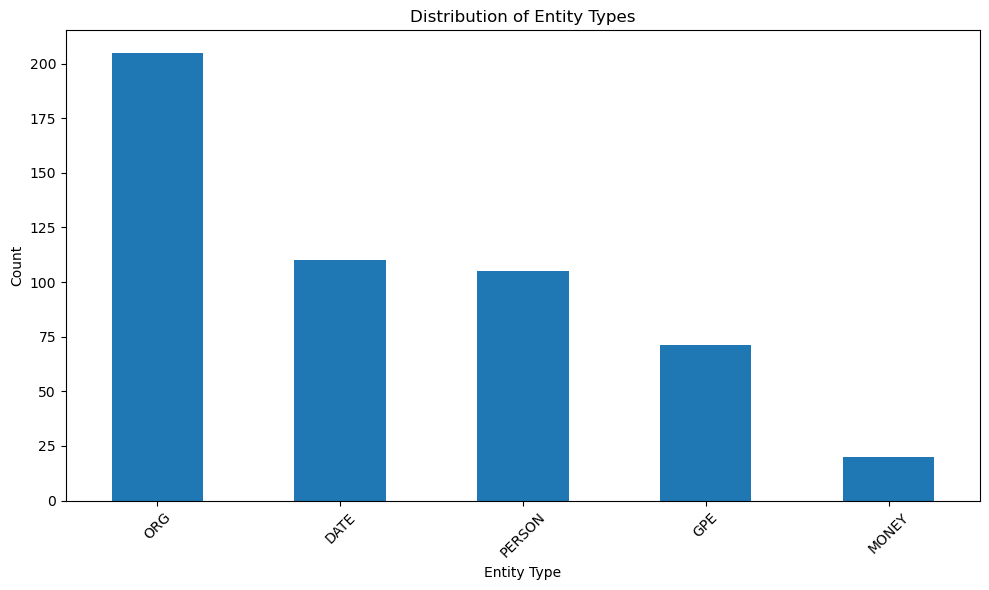


Relationships per Document:


document
https://www.channelnewsasia.com/singapore/su-wenqiang-pleads-guilty-billion-dollar-money-laundering-convicted-4234731           160
https://edition.cnn.com/2023/05/22/tech/meta-facebook-data-privacy-eu-fine/index.html                                           152
https://edition.cnn.com/2023/09/29/business/starbucks-union-wages/index.html                                                    127
https://www.channelnewsasia.com/singapore/billion-dollar-money-laundering-case-zhang-ruijin-sentenced-15-months-jail-4302416    112
https://www.euronews.com/2024/02/23/judge-convicts-former-austrian-chancellor-sebastian-kurz                                     90
https://edition.cnn.com/2024/03/05/politics/liberty-university-fined-campus-safety/index.html                                    78
Name: count, dtype: int64

In [20]:
analyzer = NewsTextAnalyzer()
analyzer.process_news_data(news_data)

print("Analysis Results:")
print(f"Total documents processed: {len(analyzer.document_metadata)}")

print("\nEntities Found:")
entity_summary = analyzer.get_entity_summary()
display(entity_summary)

print("\nRelationships Found:")
relationship_summary = analyzer.get_relationship_summary()
display(relationship_summary)

print("\nDocument Summary:")
document_summary = analyzer.get_document_summary()
display(document_summary)

analyzer.save_results("analysis_results")
print("\nResults saved to 'analysis_results' directory")

entity_type_counts = entity_summary['type'].value_counts()
print("\nEntity Type Distribution:")
display(entity_type_counts)

plt.figure(figsize=(10, 6))
entity_type_counts.plot(kind='bar')
plt.title('Distribution of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

relationship_counts = relationship_summary['document'].value_counts()
print("\nRelationships per Document:")
display(relationship_counts)
